## 5. Regression Models

In [1]:
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys
import seaborn as sns
module_path = '{}\\'.format(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..')))
sys.path.append(module_path)

from analysis.predictive.settings import TIME_WINDOW
from feature_engineering import feature_engineer, drop_cols
from grid_search import get_best_model
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from model_comparer import ModelComparer
from process_pred import get_pred_values, store_values
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from stack_model_comparer import StackModelComparer
from xgboost import XGBRegressor

%matplotlib inline

C:\Users\terry\Anaconda3\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# Read data from the data folder
file_directory = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '')) + '\\'
sample = False
sample_size = 10000

# Window size for moving averages
max_window = TIME_WINDOW

try:
    # Read data from directory and format date value
    df_combined = pd.read_csv(file_directory + 'data/processed/horse_race_combined.csv', low_memory=False, index_col=0)
    df_combined['run_date'] = df_combined['run_date'].apply(lambda x: pd.Timestamp(x))
    df_combined = df_combined.sort_values(['horse_id', 'run_date'])
    
    # Sample the dataframe if specified
    if sample:
        df_combined = df_combined.sort_values('run_date').iloc[:sample_size]
        
    # Set multi-index
    df_combined.set_index(['horse_id', 'run_date'], inplace=True)

    # Read data from those with first occurrence and drop some columns
    first_occur_df = pd.read_csv(file_directory + 'data/processed/first_occurrence_race.csv', low_memory=False, index_col=0)
    first_occur_df['run_date'] = first_occur_df['run_date'].apply(pd.Timestamp)
    drop_cols(first_occur_df)
    first_occur_df.sort_values(['horse_id', 'run_date'], inplace=True)
    first_occur_df.set_index(['horse_id', 'run_date'], inplace=True)
    
    # Filter current dataframe by removing those without prior time information
    df_combined = df_combined[~df_combined.index.isin(first_occur_df.index)]
except FileNotFoundError:
    # Do some data transformation if file is not found
    horse_race_df = pd.read_csv(file_directory + 'data/processed/horse_race.csv', low_memory=False, index_col=0)
    horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)
    horse_race_df['run_date'] = horse_race_df['run_date'].apply(pd.Timestamp)
    horse_race_df = horse_race_df.sort_values(['horse_id', 'run_date'])
    drop_cols(horse_race_df)
    
    # Do dependent variable feature engineering
    df_combined = horse_race_df.set_index(['horse_id', 'run_date'])
    df_combined['run_time_diff'] = df_combined['run_time_1000'].diff()
    df_combined['last_run_time'] = df_combined['run_time_1000'] - df_combined['run_time_diff']
    df_combined['run_time_quo'] = df_combined['run_time_1000'] / df_combined['last_run_time']
    df_combined['run_time_mean'] = df_combined['last_run_time']
    
    # Cast dataframe to primitive types and iteratively visit to get mean and median value
    df_reset = df_combined['run_time_mean'].reset_index()
    horse_id_lst = list(df_reset['horse_id'])
    run_time_mean_lst = list(df_reset['run_time_mean'])
    new_run_time_mean_lst = []
    new_run_time_median_lst = []
    curr_index = horse_id_lst[0]
    curr_count = 0
    curr_sum = 0
    curr_stored = []
    for index, value in zip(horse_id_lst, run_time_mean_lst):
        if index != curr_index:
            curr_count = 1
            curr_sum = value
            curr_index = index
            curr_stored = [value]
        else:
            curr_count += 1
            curr_sum += value
            curr_stored.append(value)
        new_run_time_mean_lst.append(curr_sum / (curr_count * 1.0))
        new_run_time_median_lst.append(np.median(curr_stored))
    df_combined['run_time_mean'] = pd.Series(new_run_time_mean_lst, index=df_combined.index)
    df_combined['run_time_median'] = pd.Series(new_run_time_median_lst, index=df_combined.index)
    
    # Get moving average and exponential moving average values
    for window in range(2, max_window + 1):
        ma = df_combined.groupby(level=0)['run_time_1000'].rolling(window).mean().groupby(level=0).shift(1)
        ma = ma.reset_index(level=1)['run_time_1000'].reset_index()
        ewma = df_combined.groupby(level=0)['run_time_1000'].apply(lambda series: series.ewm(ignore_na=True, 
                                                                                             min_periods=window, 
                                                                                             adjust=True,
                                                                                             com=0.030927835051546).mean())
        ewma = ewma.groupby(level=0).shift(1)
        df_combined['run_time_ma_window_%s' % str(window)] = ma.set_index(['horse_id', 'run_date'])['run_time_1000']
        df_combined['run_time_ewma_window_%s' % str(window)] = ewma
        
    # Output data files
    df_combined.reset_index().to_csv('data/processed/horse_race_combined.csv', encoding='utf-8')

In [3]:
# Visualize dependent variable columns
dependent = ['run_time_1000',
             'run_time_diff', 'run_time_quo', 
             'run_time_mean', 'run_time_median'] + \
            ['run_time_ma_window_%s' % str(idx) for idx in range(2, max_window + 1)] + \
            ['run_time_ewma_window_%s' % str(idx) for idx in range(2, max_window + 1)]

# Separate X and y dataframe
df_combined_y = df_combined[dependent].copy()
df_combined_x = df_combined[list(filter(lambda x: x not in dependent, df_combined.columns))].copy()

# Initiate mapping dict
df_y_original_dict = {}
df_y_original_dict['run_time_diff'] = df_combined_x['last_run_time']
df_y_original_dict['run_time_quo'] = df_combined_x['last_run_time']

for col_name in dependent[3:]:
    # Do some mapping for modelling use
    df_combined_y[col_name + '_diff'] = df_combined_y['run_time_1000'] - df_combined_y[col_name]
    df_combined_y[col_name + '_quo'] = df_combined_y['run_time_1000'] / df_combined_y[col_name]
    df_y_original_dict[col_name + '_diff'] = df_combined_y[col_name]
    df_y_original_dict[col_name + '_quo'] = df_combined_y[col_name]
    df_combined_y.drop(col_name, axis=1, inplace=True)
    
# Get an overview of data
df_combined_y[list(filter(lambda x: 'diff' in x or 'quo' in x, df_combined_y.columns))].T

horse_id                             1986102130          1989107128  \
run_date                    2000-01-29 15:40:00 2000-02-05 13:45:00   
run_time_diff                          1.642857           -1.146258   
run_time_quo                           1.027381            0.983224   
run_time_mean_diff                          NaN            2.547192   
run_time_mean_quo                           NaN            1.039409   
run_time_median_diff                        NaN            2.547192   
run_time_median_quo                         NaN            1.039409   
run_time_ma_window_2_diff                   NaN                 NaN   
run_time_ma_window_2_quo                    NaN                 NaN   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN                 NaN   
run_time_ewma_window_2_quo                  NaN                 NaN   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                                                             \
run_date                    2000-03-11 15:10:00 2000-04-15 15:30:00   
run_time_diff                          0.510490            2.697936   
run_time_quo                           1.007599            1.039856   
run_time_mean_diff                     2.208618            4.354399   
run_time_mean_quo                      1.033728            1.065940   
run_time_median_diff                   0.510490            2.953181   
run_time_median_quo                    1.007599            1.043792   
run_time_ma_window_2_diff             -0.062639            2.953181   
run_time_ma_window_2_quo               0.999076            1.043792   
run_time_ma_window_3_diff                   NaN            2.656177   
run_time_ma_window_3_quo                    NaN            1.039215   
run_time_ewma_window_2_diff            0.477103            2.712237   
run_time_ewma_window_2_quo             1.007098            1.040076   
run_time_ewma_window_3_diff                 NaN            2.712237   
run_time_ewma_window_3_quo                  NaN            1.040076   

horse_id                             1990104469                      \
run_date                    2000-03-18 11:45:00 2000-04-15 15:30:00   
run_time_diff                          1.279356            1.830030   
run_time_quo                           1.019112            1.026826   
run_time_mean_diff                    -0.446069            1.532651   
run_time_mean_quo                      0.993504            1.022369   
run_time_median_diff                  -0.446069            1.830030   
run_time_median_quo                    0.993504            1.026826   
run_time_ma_window_2_diff                   NaN            2.469709   
run_time_ma_window_2_quo                    NaN            1.036545   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN            1.867293   
run_time_ewma_window_2_quo                  NaN            1.027387   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                             1991100019                      \
run_date                    2000-02-12 15:45:00 2000-03-19 15:00:00   
run_time_diff                          0.214286           -1.160714   
run_time_quo                           1.003567            0.980746   
run_time_mean_diff                    -4.396341           -4.091609   
run_time_mean_quo                      0.932032            0.935276   
run_time_median_diff                  -4.396341           -1.160714   
run_time_median_quo                    0.932032            0.980746   
run_time_ma_window_2_

In [ ]:
smc = StackModelComparer(df_combined_x, df_combined_y, df_y_original_dict, df_combined)

Split training and testing set by date range with 0.85 ratio:
Training set date range: 2000-01-15 10:55:00 -> 2014-08-02 15:10:00
Testing set date range: 2014-08-02 15:25:00 -> 2018-02-18 16:25:00
[>>>>>>>>>>>>>>>]: Reading and transforming prediction file named tuned/run_time_ewma_window_3_diff.csv


In [ ]:
smc.add_model(LinearRegression, 'OLS', fit_intercept=True)
smc.add_model(XGBRegressor, 'XGB (0.1LR)', learning_rate=0.1)
smc.add_model(RandomForestRegressor, 'RF (6MD, 20E)', max_depth=6, n_estimators=20)
smc.add_model(GradientBoostingRegressor, 'GBM (6MD, 0.1LR)', n_estimators=100,
              max_depth=6, min_samples_split=2, learning_rate=0.1)
smc.add_model(MLPRegressor, 'ANN (normalized, 0.001LR, 150HL)',
              max_iter=100000, learning_rate_init=0.001, hidden_layer_sizes=(150,), activation='tanh')
smc.add_model(SVR, 'SVM', C=0.8)

[>>>>>>>>>>>>>>>]: Performing analysis on column run_time_ewma_window_3_diff for model OLS (Size: (417908, 6))
Added model named OLS 
[>>>>>>>>>>>>>>>]: Performing analysis on column run_time_ewma_window_3_diff for model XGB (0.1LR) (Size: (417908, 6))
Added model named XGB (0.1LR) 
[>>>>>>>>>>>>>>>]: Performing analysis on column run_time_ewma_window_3_diff for model RF (6MD, 20E) (Size: (417908, 6))
Added model named RF (6MD, 20E) 
[>>>>>>>>>>>>>>>]: Performing analysis on column run_time_ewma_window_3_diff for model GBM (6MD, 0.1LR) (Size: (417908, 6))
Added model named GBM (6MD, 0.1LR) 
[>>>>>>>>>>>>>>>]: Performing analysis on column run_time_ewma_window_3_diff for model ANN (normalized, 0.001LR, 150HL) (Size: (417908, 6))
Added model named ANN (normalized, 0.001LR, 150HL) 


In [ ]:
# Set some specs for plotting
meta_report = smc.get_report(filter_word='RMSE')
mpl.rcParams['figure.figsize    '] = (16.0, 8.0)
mpl.style.use('ggplot')
sns.heatmap(meta_report.astype(float), annot=True, fmt='.2f', cmap=cmocean.cm.curl)

## 5.1 Baseline Regression Models and Stacking

In [5]:
try:
    # Get report directory
    report_directory = file_directory + 'predictive/report/'
    
    # Initiate class object
    r_square_score = make_scorer(ModelComparer.get_r_squared, greater_is_better=True)
    rmse_score = make_scorer(ModelComparer.get_rmse, greater_is_better=False)
    mc = ModelComparer(df_combined_x, df_combined_y, df_y_original_dict, sampled=sample, random_state=37)
    
    rmse_report = pd.read_csv(report_directory + 'rmse_report_baseline.csv', index_col=0)
    rsquare_report = pd.read_csv(report_directory + 'rsquare_report_baseline.csv', index_col=0)
    meta_report = pd.read_csv(report_directory + 'meta_report_baseline.csv', index_col=0)
except FileNotFoundError:
    # Add base model
    mc.add_model(LinearRegression, model_name='OLS - Base Model', fit_intercept=True)
    mc.add_model(XGBRegressor, 'XGB - Base Model (0.1LR)', learning_rate=0.1)
    mc.add_model(DecisionTreeRegressor, 'DT - Base Model (6MD)', max_depth=6)
    mc.add_model(RandomForestRegressor, 'RF - Base Model (6MD, 20E)', max_depth=6, n_estimators=20)
    mc.add_model(GradientBoostingRegressor, 'GBM - Base Model (6MD, 0.1LR)', 
                 n_estimators=100, max_depth=6, min_samples_split=2, learning_rate=0.1)

    # Add ANN with verbose as True
    mc.add_model(MLPRegressor, 'ANN - Base Model (normalized, 100000MI, 0.01LR, 300HL)',
                 max_iter=100000, learning_rate_init=0.01, hidden_layer_sizes=(300,), activation='tanh')

    # Stacking model
    ols_base = LinearRegression(fit_intercept=True)
    xgb_base = XGBRegressor(learning_rate=0.1)
    dt_base = DecisionTreeRegressor(max_depth=6)
    rf_base = RandomForestRegressor(max_depth=6, n_estimators=20)
    gbm_base = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_split=2, learning_rate=0.1)
    ann_base = MLPRegressor(max_iter=100000, learning_rate_init=0.01, hidden_layer_sizes=(300,), activation='tanh')
    ols_meta = LinearRegression(fit_intercept=True)
    mc.add_model(StackingRegressor, 'Meta - OLS',
                 regressors=[ols_base, xgb_base, dt_base, rf_base, gbm_base, ann_base], 
                 meta_regressor=ols_meta,
                 store_train_meta_features=True)

    # Get model report
    rmse_report = mc.get_report(filter_word='RMSE')
    rsquare_report = mc.get_report(filter_word='R^2')
    rmse_report.to_csv(file_directory + 'predictive/report/rmse_report_baseline.csv')
    rsquare_report.to_csv(file_directory + 'predictive/report/rsquare_report_baseline.csv')
    
    meta_report = mc.get_meta_report()
    meta_report.to_csv(file_directory + 'predictive/report/meta_report_baseline.csv') 

Split training and testing set by date range with 0.85 ratio:
Training set date range: 2000-01-15 10:55:00 -> 2014-08-02 15:10:00
Testing set date range: 2014-08-02 15:25:00 -> 2018-02-18 16:25:00


### 5.1.1 Feature Importances of Stacking Model

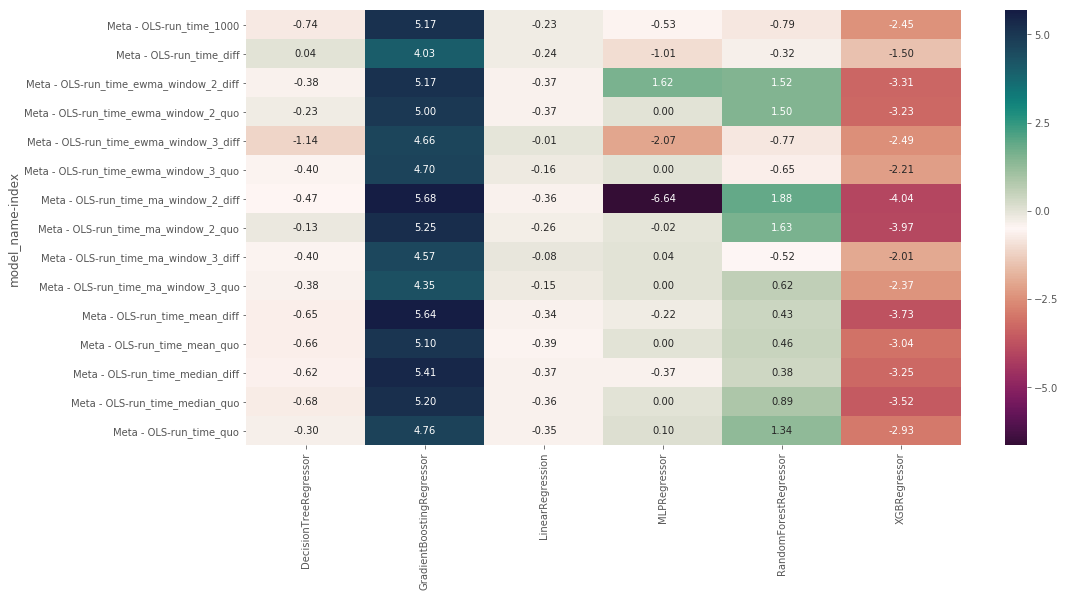

In [6]:
# Set some specs for plotting
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
sns.heatmap(meta_report.reset_index().set_index(['model_name', 'index']).astype(float), annot=True, fmt='.2f', cmap=cmocean.cm.curl_r)

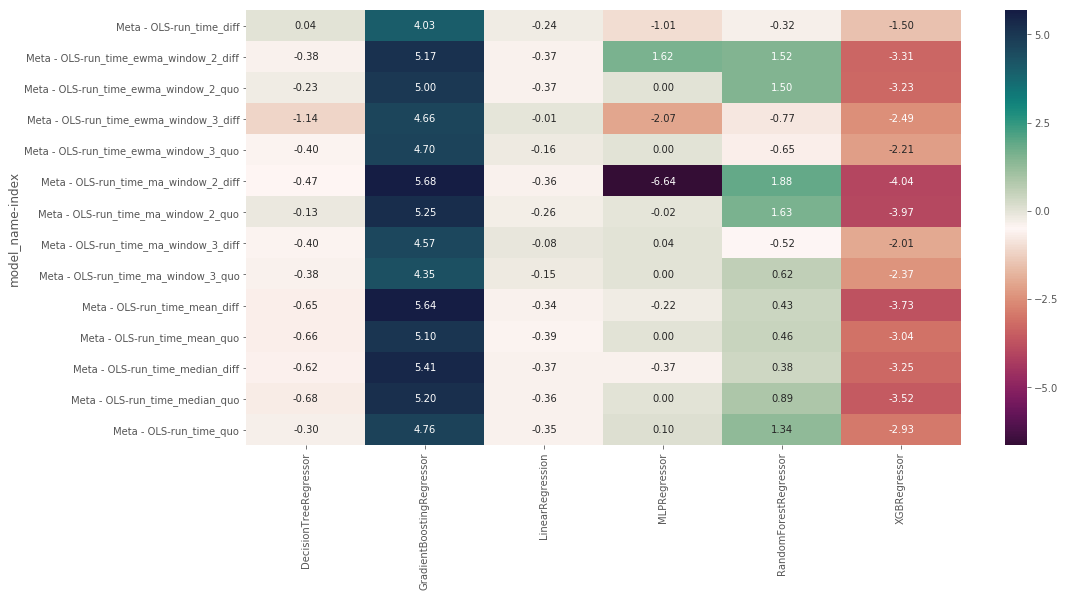

In [7]:
# Set some specs for plotting and remove the first row (run_time_1000 prediction)
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
sns.heatmap(meta_report.reset_index().set_index(['model_name', 'index']).iloc[1:, :].astype(float), annot=True, fmt='.2f', cmap=cmocean.cm.curl_r)

### 5.1.2 Root Mean Square Error (RMSE) Performance Report

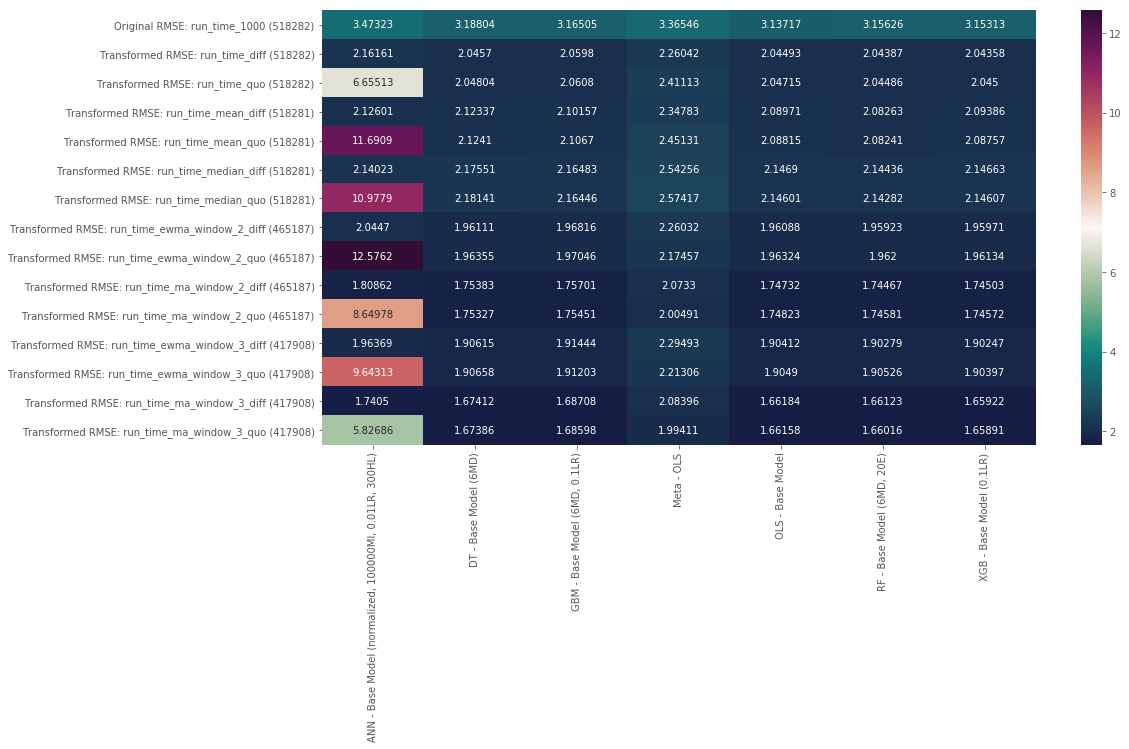

In [8]:
# Get performance of all models
value_df = rmse_report.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl) 

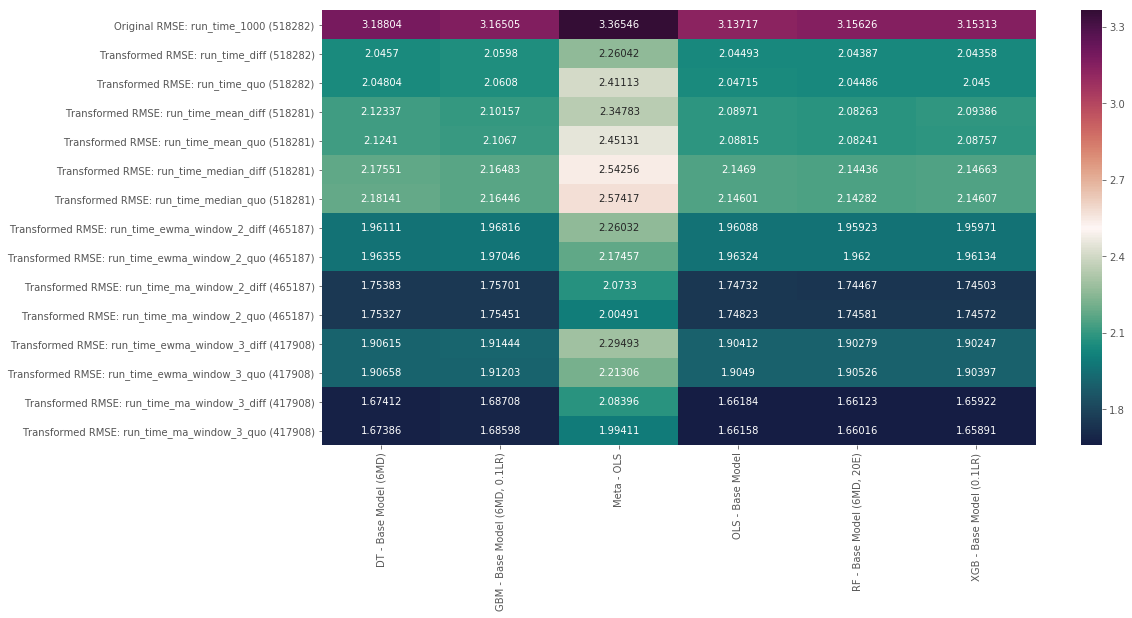

In [9]:
# Remove first columns (ANN)
value_df = rmse_report.dropna().astype(float).iloc[:, 1:]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl) 

### 5.1.3 R-Squared Performance Report

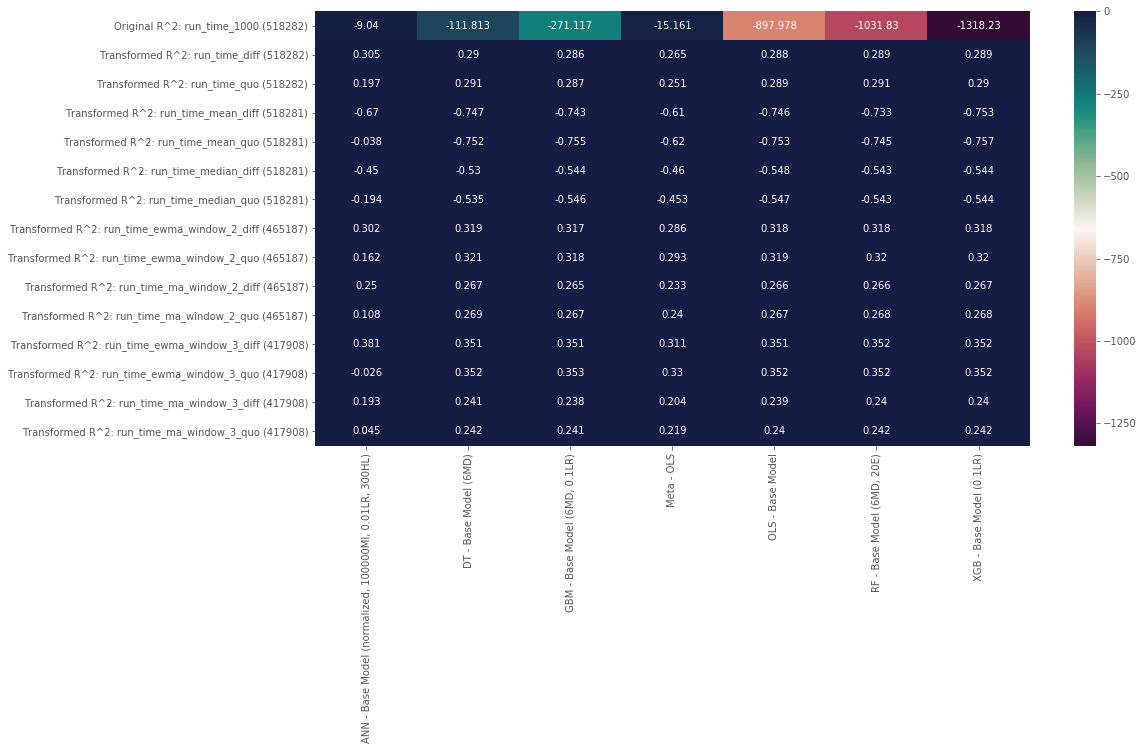

In [10]:
# Get performance of all models
value_df = rsquare_report.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl_r)

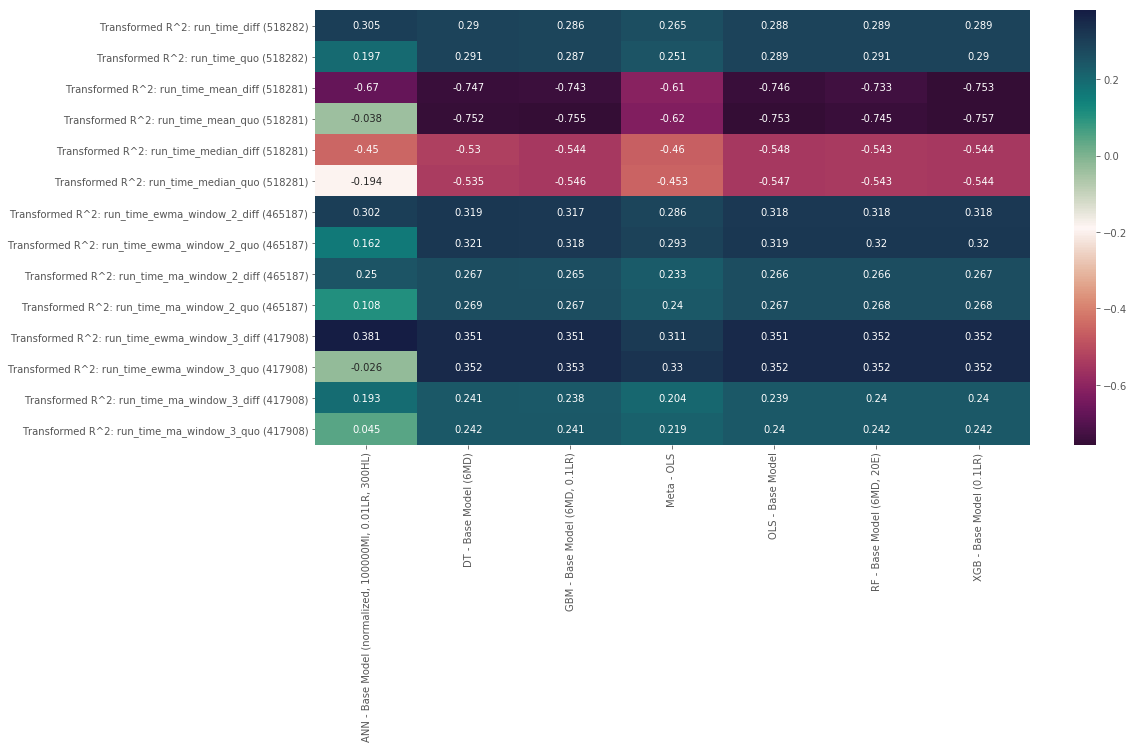

In [11]:
# Remove first row (run_time_1000 prediction)
value_df = rsquare_report.dropna().astype(float).iloc[1:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl_r)

### 5.1.4 Predicted Values of Baseline and Meta Models

In [12]:
# Get prediction values from all models
try:
    base_pred = get_pred_values(mc, 'baselines', is_meta=False, original_df_combined=df_combined)
    print()
    meta_pred = get_pred_values(mc, 'baselines', is_meta=True, original_df_combined=df_combined)
except FileNotFoundError:
    store_values(mc, 'baselines')

[>>>>>>>>>>>>>>>]: Reading and transforming prediction file named baselines/run_time_ewma_window_3_diff.csv


## 5.2 Grid Search

### 5.2.1 Artificial Nerural Network Hyper-parameter Tuning 

In [13]:
# Do exhaustive search on MLP regressor
ann_tuned_params = {
    'activation': ['relu', 'tanh'], 
    'learning_rate_init': [0.01, 0.001, 0.002], 
    'max_iter': [100000, ], 
    'hidden_layer_sizes': [(100, ), (150, ), (200, ), (250, ), (300, ), (350, )]
}
get_best_model(mc, 'ann', MLPRegressor, ann_tuned_params, n_jobs=1, randomized=False,
               scoring=rmse_score, verbose=2,
               filter_func=lambda x: 'run_time_1000' in x)

,activation,hidden_layer_sizes,learning_rate_init,max_iter,score
run_time_1000,tanh,"(150,)",0.001,100000,3.20925


### 5.2.2 Random Forest Hyper-parameter Tuning

In [14]:
# Do randomized grid search on random forest regressor
rf_tuned_params = {
    'n_estimators': np.arange(20, 70, 10), 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(5, 10, 1)
}

get_best_model(mc, 'rf', RandomForestRegressor, rf_tuned_params, n_jobs=-1, randomized=True,
               scoring=rmse_score, verbose=2, 
               filter_func=lambda x: 'run_time_1000' in x)

,max_depth,max_features,n_estimators,score
run_time_1000,8,sqrt,40,3.20408


### 5.2.3 XGBoost Hyper-parameter Tuning

In [15]:
# Do randomized grid search on XGBoost regressor
xgb_tuned_params = {
    'max_depth': np.arange(3, 11, 2),
    'subsample': np.arange(0.6, 1.01, 0.1),
    'colsample_bytree': np.arange(0.6, 1.2, 0.2),
    'min_child_weight': np.arange(1, 11, 3),
    'gamma': np.arange(0, 0.5, 0.1),
    'reg_alpha': [0, 0.001, 0.01]
}
get_best_model(mc, 'xgb', XGBRegressor, xgb_tuned_params, n_jobs=-1, randomized=True,
               scoring=rmse_score, verbose=2, 
               filter_func=lambda x: 'run_time_1000' in x)

,colsample_bytree,gamma,max_depth,min_child_weight,reg_alpha,score,subsample
run_time_1000,0.8,0.3,3.0,7.0,0.01,3.203065,0.6


### 5.2.4 Gradient Boost Machine Hyper-parameter Tuning

In [16]:
# Do randomized grid search on GBM regressor
gbm_tuned_params = {
    'n_estimators': np.arange(100, 220, 20),
    'max_depth': np.arange(5, 12, 2),
    'min_samples_split': np.arange(100, 1000, 200),
    'min_samples_leaf': np.arange(30, 90, 20),
    'max_features': np.arange(20, 50, 10),
    'subsample': np.arange(0.6, 1, 0.1)
}
get_best_model(mc, 'gbm', GradientBoostingRegressor, gbm_tuned_params, n_jobs=-1, randomized=True,
               scoring=rmse_score, verbose=2, 
               filter_func=lambda x: 'run_time_1000' in x)

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,score,subsample
run_time_1000,5.0,20.0,50.0,500.0,100.0,3.203236,0.8


## 5.3 Hyperparameter-tuned Models

In [17]:
try:
    # Initiate class object
    rmse_report_tuned = pd.read_csv(report_directory + 'rmse_report_tuned.csv', index_col=0)
    rsquare_report_tuned = pd.read_csv(report_directory + 'rsquare_report_tuned.csv', index_col=0)
    meta_report_tuned = pd.read_csv(report_directory + 'meta_report_tuned.csv', index_col=0)
except FileNotFoundError:
    # Add base model
    mc_tuned = ModelComparer(df_combined_x, df_combined_y, df_y_original_dict, sampled=sample, random_state=37)
    mc_tuned.add_model(LinearRegression, model_name='OLS - Base Model', fit_intercept=True)
    mc_tuned.add_model(DecisionTreeRegressor, 'DT - Base Model (6MD)', max_depth=6)
    mc_tuned.add_model(XGBRegressor, 'XGB - Tuned Model', 
                       learning_rate=0.1, colsample_bytree=0.8, gamma=0.3, max_depth=3, 
                       min_child_weight=7, reg_alpha=0.01, subsample=0.6)
    mc_tuned.add_model(RandomForestRegressor, 'RF - Tuned Model', 
                       max_depth=8, n_estimators=40, max_features='sqrt')
    mc_tuned.add_model(GradientBoostingRegressor, 'GBM - Tuned Model', 
                       n_estimators=100, max_depth=5, max_features=20, min_samples_leaf=50, 
                       min_samples_split=500, subsample=0.8, learning_rate=0.1)

    # Add ANN with verbose as True
    mc_tuned.add_model(MLPRegressor, 'ANN - Tuned Model (normalized)',
                       max_iter=100000, learning_rate_init=0.001, hidden_layer_sizes=(150,), activation='tanh')

    # Baseline models
    ols_base = LinearRegression(fit_intercept=True)
    dt_base = DecisionTreeRegressor(max_depth=6)

    # Tuned models
    xgb_tuned = XGBRegressor(learning_rate=0.1, colsample_bytree=0.8, gamma=0.3, max_depth=3, 
                             min_child_weight=7, reg_alpha=0.01, subsample=0.6)
    rf_tuned = RandomForestRegressor(max_depth=8, n_estimators=40, max_features='sqrt')
    gbm_tuned = GradientBoostingRegressor(n_estimators=100, max_depth=5, max_features=20, min_samples_leaf=50, 
                                          min_samples_split=500, subsample=0.8, learning_rate=0.1)
    ann_tuned = MLPRegressor(max_iter=100000, learning_rate_init=0.001, hidden_layer_sizes=(150,), activation='tanh')

    # Add OLS as stacking model and get predictions
    ols_meta = LinearRegression(fit_intercept=True)
    mc_tuned.add_model(StackingRegressor, 'Meta - OLS', 
                       regressors=[ols_base, dt_base, xgb_tuned, rf_tuned, gbm_tuned, ann_tuned], 
                       meta_regressor=ols_meta,
                       store_train_meta_features=True)

    # Get model report
    rmse_report_tuned = mc_tuned.get_report(filter_word='RMSE')
    rsquare_report_tuned = mc_tuned.get_report(filter_word='R^2')
    rmse_report_tuned.to_csv(file_directory + 'predictive/report/rmse_report_tuned.csv')
    rsquare_report_tuned.to_csv(file_directory + 'predictive/report/rsquare_report_tuned.csv')
    
    meta_report_tuned = mc_tuned.get_meta_report()
    meta_report_tuned.to_csv(file_directory + 'predictive/report/meta_report_tuned.csv')

### 5.3.1 Feature Importances of Stacking Model

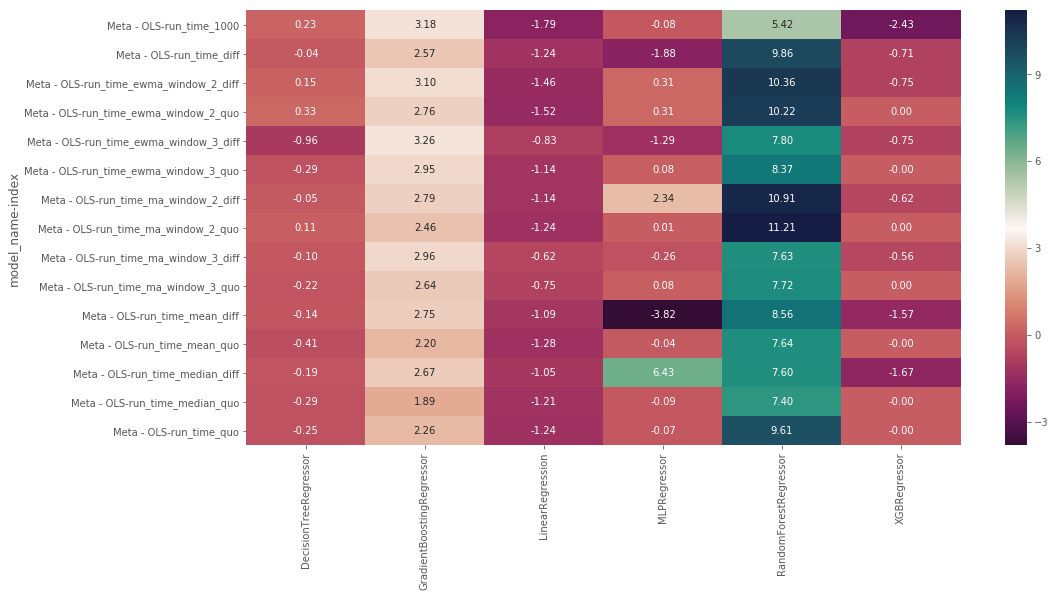

In [18]:
# Set some specs for plotting
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
sns.heatmap(meta_report_tuned.reset_index().set_index(['model_name', 'index']).iloc[:, :].astype(float), annot=True, fmt='.2f', cmap=cmocean.cm.curl_r)

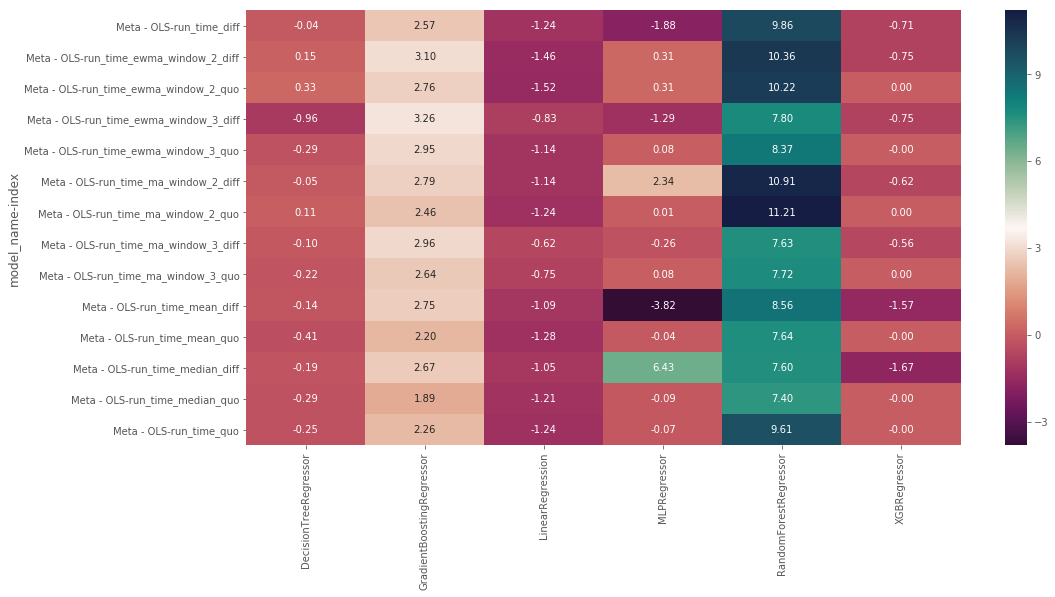

In [19]:
# Set some specs for plotting and remove the first row (run_time_1000 prediction)
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
sns.heatmap(meta_report_tuned.reset_index().set_index(['model_name', 'index']).iloc[1:, :].astype(float), annot=True, fmt='.2f', cmap=cmocean.cm.curl_r)

### 5.3.2 Root Mean Square Error (RMSE) Performance Report

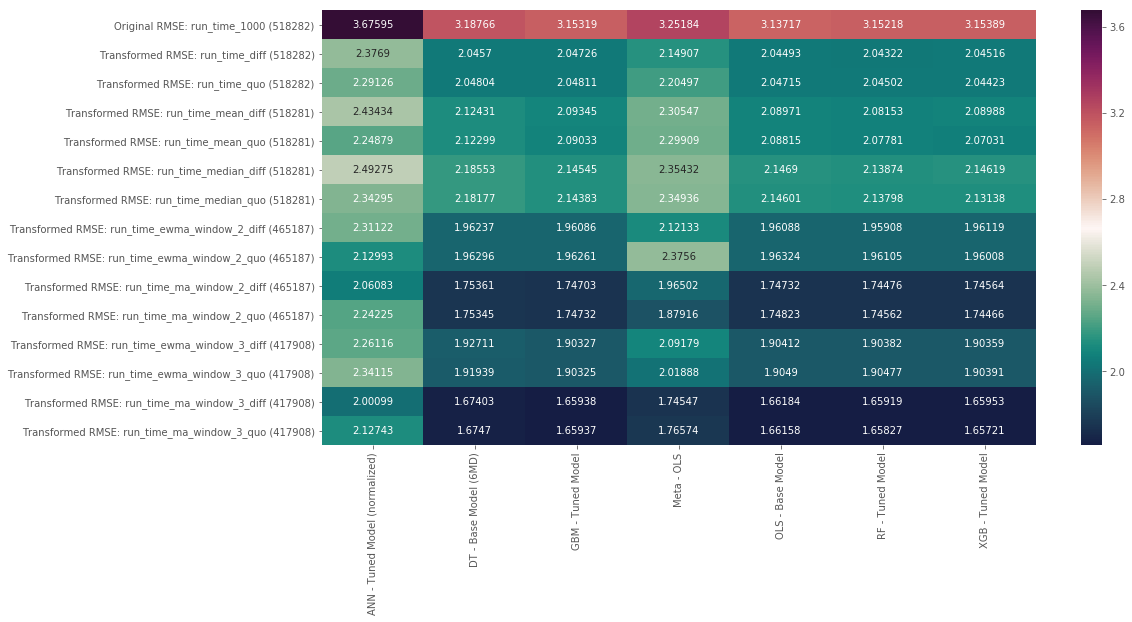

In [20]:
value_df = rmse_report_tuned.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl) 

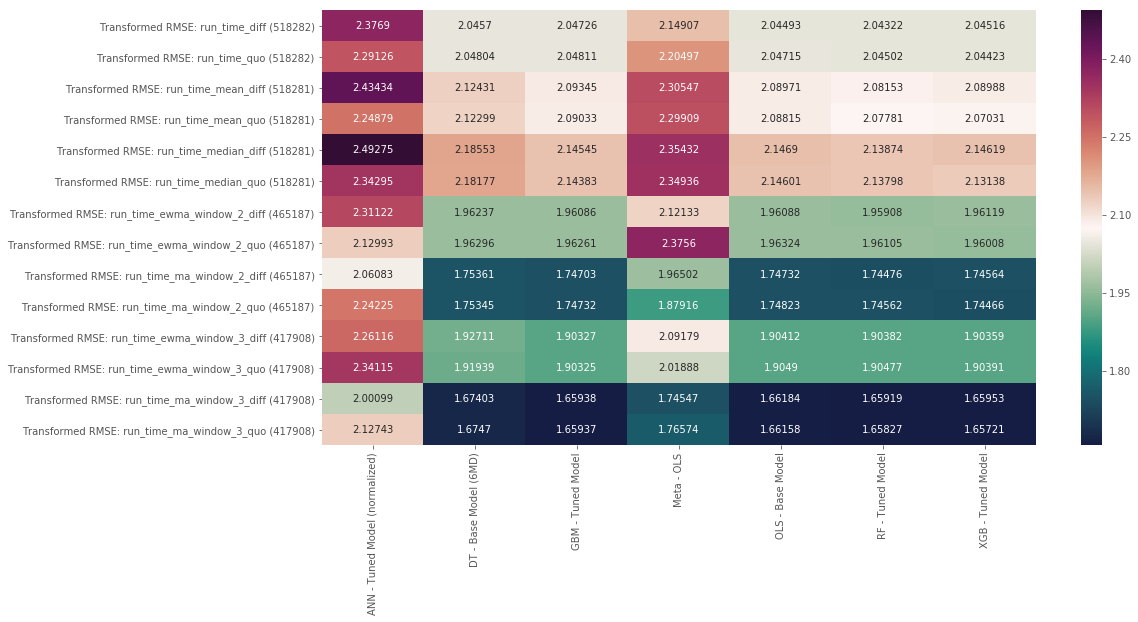

In [21]:
value_df = rmse_report_tuned.dropna().astype(float).iloc[1:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl) 

### 5.3.3 R-Squared Performance Report

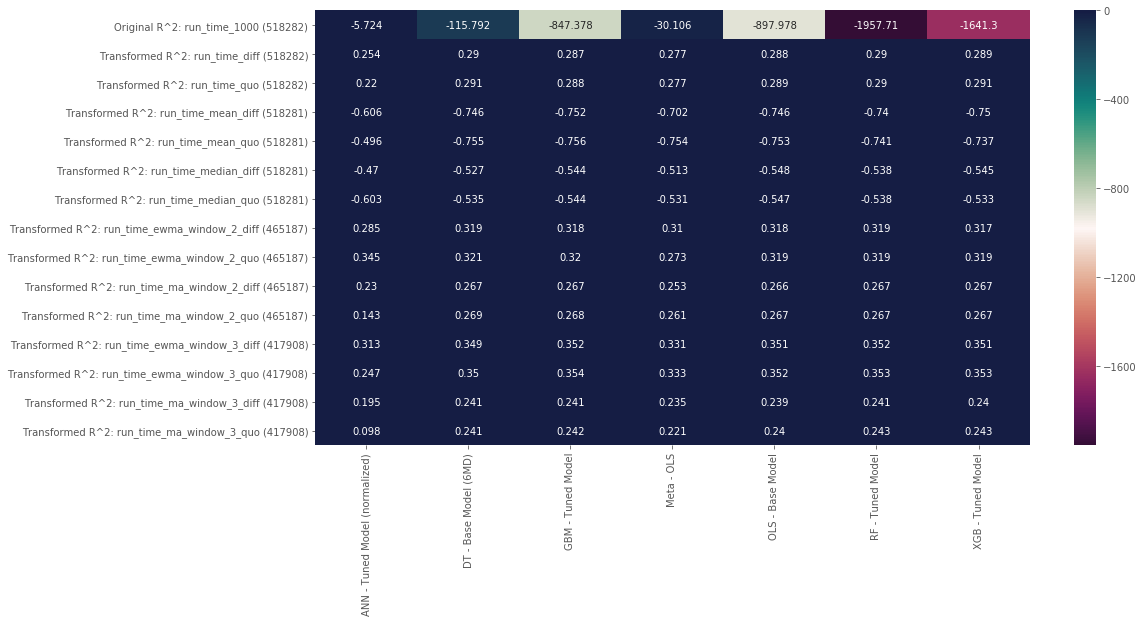

In [22]:
value_df = rsquare_report_tuned.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl_r)

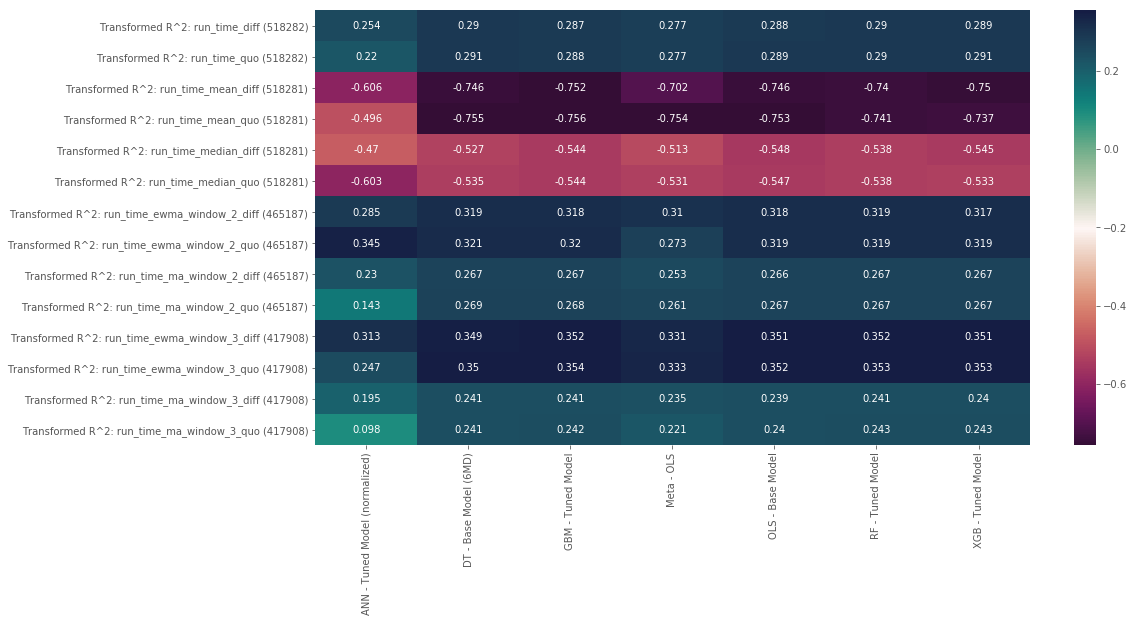

In [23]:
value_df = rsquare_report_tuned.dropna().astype(float).iloc[1:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap=cmocean.cm.curl_r)

### 5.3.4 Predicted Values of Baseline and Meta Models

In [6]:
# Get prediction values from all models
try:
    base_pred_tuned = get_pred_values('tuned', is_meta=False, original_df_combined=df_combined, join_place=False)
    print()
    meta_pred_tuned = get_pred_values('tuned', is_meta=True, original_df_combined=df_combined, join_place=False)
except FileNotFoundError:
    store_values(mc_tuned, 'tuned')

[>>>>>>>>>>>>>>>]: Reading and transforming prediction file named tuned/run_time_ewma_window_3_diff.csv


## 5.4 Other Stacking (Second Stage) Models